In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

Bcftools procedure for filtering:
Filter out all samples with less than 10X coverage. Remove all variants with maf below 10%. 
Males are included in chrX analysis.

Concat the different GVCFs aligned to the same reference, remove all sites with missing data (possibly have to remove inds below 20X).

In [2]:
metadata_dir = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"


metadata_dirs = glob.glob(metadata_dir+"*_individuals.txt")

df_l = []
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    df_l.append(dir_metadata)
all_inds = pd.concat(df_l)
d_pca_var = {}

Test run based on a single Papio_anubis chromosome (chrX and a single autosome).

In [3]:
metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"

metadata_folders_pca = ['/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Papio_individuals.txt'] # glob.glob(metadata_path+"Pa*_individuals.txt")

for folder in metadata_folders_pca:
    metadata_df = pd.read_csv(folder, sep="\t")
    short_form = folder.split("/")[-1].split("_")[0]
    regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
    for REFERENCE_FOLDER in metadata_df.REFERENCE_FOLDER.unique():
        reference = REFERENCE_FOLDER
        print(reference)
        zarr_input = []
        aut = regions_df.loc[(regions_df.FEMALE_PLOIDY == 2) &
                              (regions_df.MALE_PLOIDY == 2) &
                              (regions_df.END >= 1000000) & 
                              (regions_df.REFERENCE_FOLDER == reference)]
        chrX = regions_df.loc[(regions_df.FEMALE_PLOIDY == 2) &
                              (regions_df.MALE_PLOIDY == 1) &
                              (regions_df.END >= 1000000) & 
                              (regions_df.REFERENCE_FOLDER == reference)]

Papio_anubis_ssp


In [4]:
xarray_l = []
for x in aut.CONTIG_ID:
    print(x)
    ds = sg.load_dataset("../zarr_data/Papio_anubis_ssp_pca/"+x, drop_variables=["variant_allele"])
    missing_filter = 0.0
    missing_rate = ds.call_genotype_mask[:,:,0].sum(axis=1).values/ds.call_genotype_mask[:,:,0].count(axis=1).values
    ds_subset = ds.isel(variants=(missing_rate <= missing_filter))
    xarray_l.append(sg.count_variant_alleles(ds_subset)[["variant_allele_count",
                                         "call_genotype", "call_genotype_mask"]])
ds_concat = xr.concat(xarray_l, dim="variants")

NC_044976.1
NC_044977.1
NC_044978.1
NC_044979.1
NC_044980.1
NC_044981.1
NC_044982.1
NC_044983.1
NC_044984.1
NC_044985.1
NC_044986.1
NC_044987.1
NC_044988.1
NC_044989.1
NC_044990.1
NC_044991.1
NC_044992.1
NC_044993.1
NC_044994.1
NC_044995.1


In [5]:
pca_results = sg.pca(ds_concat).compute()

In [6]:
pca_df_anubis = pd.DataFrame(pca_results.sample_pca_projection,
                      columns=["PC{}".format(x+1) for x in range(10)])
pca_df_anubis["GVCF_ID"] = ds.sample_id
pca_df_anubis["SPECIES_SUBSPECIES"] = pca_df_anubis["GVCF_ID"].map(dict(zip(metadata_df.GVCF_ID, metadata_df.SPECIES+"_"+metadata_df.SUBSPECIES)))
pca_df_anubis["CHROM"] = "Autosome"
pca_df_anubis.to_csv("../results/Papio_aut_pca.txt", sep="\t", index=False)

In [7]:
d_pca_var["Anubis_aut"] = pca_results.sample_pca_explained_variance_ratio
d_pca_var

{'Anubis_aut': <xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> Size: 40B
 array([0.24636586, 0.0728419 , 0.05497636, 0.05090902, 0.02618214,
        0.01719516, 0.01506165, 0.00830828, 0.00762447, 0.0073325 ],
       dtype=float32)
 Dimensions without coordinates: components}

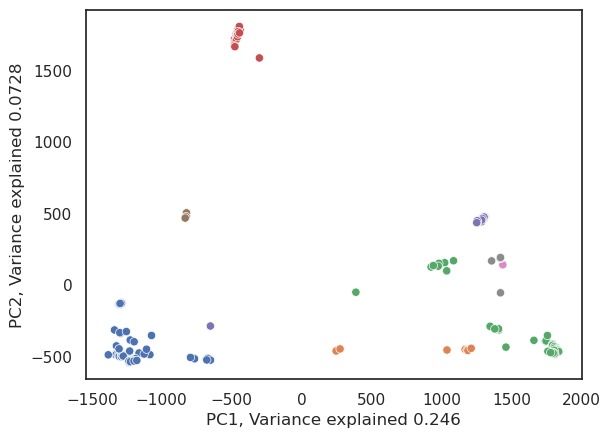

In [8]:
pcx = 0
pcy = 1
g = sns.scatterplot(data=pca_df_anubis, x="PC1", y="PC2", hue="SPECIES_SUBSPECIES", legend=False)
g.set(xlabel="PC1, Variance explained {0:.3g}".format(pca_results.sample_pca_explained_variance_ratio[pcx].values),
      ylabel="PC2, Variance explained {0:.3g}".format(pca_results.sample_pca_explained_variance_ratio[pcy].values))
#plt.legend(bbox_to_anchor=(1.39, 1))
f = g.get_figure()
f.savefig("../figures/Anubis_aut_pca.jpg", dpi=300)

Anubis chrX

In [9]:
dsX = sg.load_dataset("../zarr_data/Papio_anubis_ssp_pca/NC_044995.1", drop_variables=["variant_allele"])

In [10]:
dsX

<xarray.Dataset> Size: 854MB
Dimensions:                  (variants: 73418, samples: 251, alleles: 2,
                              genotypes: 3, ploidy: 2, contigs: 9303,
                              filters: 2, region_index_values: 74,
                              region_index_fields: 6)
Dimensions without coordinates: variants, samples, alleles, genotypes, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/40)
    call_AD                  (variants, samples, alleles) int16 74MB dask.array<chunksize=(1000, 251, 2), meta=np.ndarray>
    call_DP                  (variants, samples) int16 37MB dask.array<chunksize=(1000, 251), meta=np.ndarray>
    call_GQ                  (variants, samples) int8 18MB dask.array<chunksize=(1000, 251), meta=np.ndarray>
    call_PGT                 (variants, samples) object 147MB dask.array<chunksize=(1000, 251), meta=np.ndarray>
    call_PID                 (variants, samples) object 147MB dask.array<chunksize=(1000, 251), meta=np.ndarray>
    call_PL                  (variants, samples, genotypes) int32 221MB dask.array<chunksize=(1000, 251, 3), meta=np.ndarray>
    ...                       ...
    variant_filter           (variants, filters) bool 147kB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    variant_id               (variants) object 587kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask          (variants) bool 73kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length           (variants) int16 147kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position         (variants) int32 294kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality          (variants) float32 294kB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [11]:
# Remove variants with a high degree of missing data, non-biallelic and a maf below 10 %
# (1-maf_filter >= (allele_counts[:,1]/allele_counts.sum(axis=1)))).compute() &
# maf_filter = 0.1
#ds_subset = ds_subset.isel(variants=((maf_filter <= (allele_counts[:,1]/allele_counts.sum(axis=1)) &
#                                    (1-maf_filter >= (allele_counts[:,1]/allele_counts.sum(axis=1)))).compute()))

missing_filter = 0.0 # First try is with both males and females.
missing_rate = dsX.call_genotype_mask[:,:,0].sum(axis=1).values/dsX.call_genotype_mask[:,:,0].count(axis=1).values
ds_subset = dsX.isel(variants=(missing_rate <= missing_filter))
ds_subset = ds_subset.isel(variants =(ds_subset.call_genotype.values.max(axis=1).max(axis=1)) < 2) # Only keep bi
allele_counts = sg.count_variant_alleles(ds_subset)["variant_allele_count"]
ds_subset

<xarray.Dataset> Size: 786MB
Dimensions:                  (variants: 67643, samples: 251, alleles: 2,
                              genotypes: 3, ploidy: 2, contigs: 9303,
                              filters: 2, region_index_values: 74,
                              region_index_fields: 6)
Dimensions without coordinates: variants, samples, alleles, genotypes, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/40)
    call_AD                  (variants, samples, alleles) int16 68MB dask.array<chunksize=(994, 251, 2), meta=np.ndarray>
    call_DP                  (variants, samples) int16 34MB dask.array<chunksize=(994, 251), meta=np.ndarray>
    call_GQ                  (variants, samples) int8 17MB dask.array<chunksize=(994, 251), meta=np.ndarray>
    call_PGT                 (variants, samples) object 136MB dask.array<chunksize=(994, 251), meta=np.ndarray>
    call_PID                 (variants, samples) object 136MB dask.array<chunksize=(994, 251), meta=np.ndarray>
    call_PL                  (variants, samples, genotypes) int32 204MB dask.array<chunksize=(994, 251, 3), meta=np.ndarray>
    ...                       ...
    variant_filter           (variants, filters) bool 135kB dask.array<chunksize=(994, 2), meta=np.ndarray>
    variant_id               (variants) object 541kB dask.array<chunksize=(994,), meta=np.ndarray>
    variant_id_mask          (variants) bool 68kB dask.array<chunksize=(994,), meta=np.ndarray>
    variant_length           (variants) int16 135kB dask.array<chunksize=(994,), meta=np.ndarray>
    variant_position         (variants) int32 271kB dask.array<chunksize=(994,), meta=np.ndarray>
    variant_quality          (variants) float32 271kB dask.array<chunksize=(994,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [12]:
def haploid_double(ds, variable, dim):
    unmasked = ~ds[f"{variable}_mask"]
    overwrite = ds.call_genotype[:,:,0]
    overwrite_2 = ds.call_genotype_mask[:,:,0]
    return ds.assign(**{
        f"{variable}": ds[variable].where(
        unmasked, 
        overwrite),
        f"{variable}_mask": ds[f"{variable}_mask"].where(
        unmasked,
        overwrite_2)})


ds_subset = haploid_double(ds_subset, "call_genotype", "samples")
#~ds_subset[f"{"call_genotype"}_mask"][:1].values

In [13]:
pca_results = sg.pca(ds_subset).compute()

In [14]:
pca_results.sample_pca_projection

<xarray.DataArray 'sample_pca_projection' (samples: 251, components: 10)> Size: 10kB
array([[-2.04047485e+02, -7.99281235e+01, -2.83542881e+01, ...,
        -5.28176231e+01, -5.26761665e+01,  1.45221305e+00],
       [-1.99251175e+02, -7.66247482e+01, -2.63390141e+01, ...,
        -6.33216629e+01, -6.65183411e+01,  2.37159491e+00],
       [-2.08260025e+02, -8.10048599e+01, -2.23484364e+01, ...,
        -7.44134750e+01, -8.18489609e+01, -1.69282646e+01],
       ...,
       [ 2.25714035e+02,  5.14066582e+01, -1.12922836e+02, ...,
        -2.85758190e+01,  5.06544495e+01,  4.07672997e+01],
       [ 2.15791565e+02, -1.84579432e-01, -3.58336220e+01, ...,
        -5.60901566e+01,  1.54597902e+00, -8.06256866e+01],
       [ 2.09079849e+02,  4.42527542e+01, -1.03956566e+02, ...,
        -5.72037811e+01,  1.64607944e+01, -5.99972038e+01]], dtype=float32)
Dimensions without coordinates: samples, components

In [15]:
pca_results

<xarray.Dataset> Size: 826MB
Dimensions:                              (samples: 251, components: 10,
                                          variants: 67643, alleles: 2,
                                          genotypes: 3, ploidy: 2,
                                          contigs: 9303, filters: 2,
                                          region_index_values: 74,
                                          region_index_fields: 6)
Dimensions without coordinates: samples, components, variants, alleles,
                                genotypes, ploidy, contigs, filters,
                                region_index_values, region_index_fields
Data variables: (12/46)
    sample_pca_projection                (samples, components) float32 10kB -...
    sample_pca_component                 (variants, components) float32 3MB 0...
    sample_pca_explained_variance        (components) float32 40B 3.996e+04 ....
    sample_pca_explained_variance_ratio  (components) float32 40B 0.23 ... 0....
    sample_pca_loading                   (variants, components) float32 3MB 1...
    call_alternate_allele_count          (variants, samples) int16 34MB 0 ... 0
    ...                                   ...
    variant_filter                       (variants, filters) bool 135kB False...
    variant_id                           (variants) object 541kB '.' '.' ... '.'
    variant_id_mask                      (variants) bool 68kB True True ... True
    variant_length                       (variants) int16 135kB 1 1 1 ... 1 1 1
    variant_position                     (variants) int32 271kB 276 ... 50014125
    variant_quality                      (variants) float32 271kB 8.299e+04 ....
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [16]:
["pc{}".format(x+1) for x in range(len(pca_results.sample_pca_explained_variance))]

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10']

In [17]:
pca_results.sample_pca_projection#+pca_results.sample_pca_explained_variance

<xarray.DataArray 'sample_pca_projection' (samples: 251, components: 10)> Size: 10kB
array([[-2.04047485e+02, -7.99281235e+01, -2.83542881e+01, ...,
        -5.28176231e+01, -5.26761665e+01,  1.45221305e+00],
       [-1.99251175e+02, -7.66247482e+01, -2.63390141e+01, ...,
        -6.33216629e+01, -6.65183411e+01,  2.37159491e+00],
       [-2.08260025e+02, -8.10048599e+01, -2.23484364e+01, ...,
        -7.44134750e+01, -8.18489609e+01, -1.69282646e+01],
       ...,
       [ 2.25714035e+02,  5.14066582e+01, -1.12922836e+02, ...,
        -2.85758190e+01,  5.06544495e+01,  4.07672997e+01],
       [ 2.15791565e+02, -1.84579432e-01, -3.58336220e+01, ...,
        -5.60901566e+01,  1.54597902e+00, -8.06256866e+01],
       [ 2.09079849e+02,  4.42527542e+01, -1.03956566e+02, ...,
        -5.72037811e+01,  1.64607944e+01, -5.99972038e+01]], dtype=float32)
Dimensions without coordinates: samples, components

In [18]:
pca_results.sample_pca_explained_variance_ratio

<xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> Size: 40B
array([0.23003554, 0.06504869, 0.0522945 , 0.04609353, 0.02372572,
       0.01649078, 0.01514296, 0.00871438, 0.00811962, 0.00713975],
      dtype=float32)
Dimensions without coordinates: components

In [19]:
d_pca_var["Anubis_chrX"] = pca_results.sample_pca_explained_variance_ratio
d_pca_var

{'Anubis_aut': <xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> Size: 40B
 array([0.24636586, 0.0728419 , 0.05497636, 0.05090902, 0.02618214,
        0.01719516, 0.01506165, 0.00830828, 0.00762447, 0.0073325 ],
       dtype=float32)
 Dimensions without coordinates: components,
 'Anubis_chrX': <xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> Size: 40B
 array([0.23003554, 0.06504869, 0.0522945 , 0.04609353, 0.02372572,
        0.01649078, 0.01514296, 0.00871438, 0.00811962, 0.00713975],
       dtype=float32)
 Dimensions without coordinates: components}

In [20]:
pca_df = pd.DataFrame(pca_results.sample_pca_projection,
                      columns=["PC{}".format(x+1) for x in range(10)])
pca_df["GVCF_ID"] = pca_results.sample_id
pca_df["SPECIES_SUBSPECIES"] = pca_df["GVCF_ID"].map(dict(zip(metadata_df.GVCF_ID, metadata_df.SPECIES+"_"+metadata_df.SUBSPECIES)))
pca_df["CHROM"] = "Chromosome X"
pca_df.to_csv("../results/Papio_chrX_pca.txt", sep="\t", index=False)


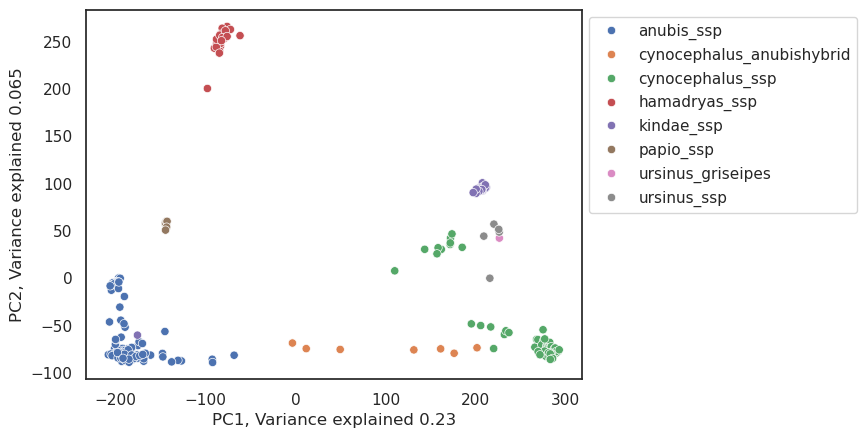

In [21]:
pcx = 0
pcy = 1
g = sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="SPECIES_SUBSPECIES")
g.set(xlabel="PC1, Variance explained {0:.3g}".format(pca_results.sample_pca_explained_variance_ratio[pcx].values),
      ylabel="PC2, Variance explained {0:.3g}".format(pca_results.sample_pca_explained_variance_ratio[pcy].values))
plt.legend(bbox_to_anchor=(1.0, 1))

In [22]:
metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"

metadata_folders_pca = ['/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Macaca_individuals.txt'] # glob.glob(metadata_path+"Pa*_individuals.txt")

for folder in metadata_folders_pca:
    metadata_df = pd.read_csv(folder, sep="\t")
    short_form = folder.split("/")[-1].split("_")[0]
    regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
    metadata_df = metadata_df.loc[metadata_df.REFERENCE_FOLDER.isin(["Papio_anubis_ssp", "Macaca_mulatta_ssp"])]
    for REFERENCE_FOLDER in metadata_df.REFERENCE_FOLDER.unique():
        reference = REFERENCE_FOLDER
        gvcfs = metadata_df.GVCF_FOLDER.unique()
        print(reference)
        zarr_input = []
        regions_df = regions_df.loc[regions_df.REFERENCE_FOLDER == reference]
        aut = regions_df.loc[(regions_df.FEMALE_PLOIDY == 2) &
                              (regions_df.MALE_PLOIDY == 2) &
                              (regions_df.END >= 1000000) & 
                              (regions_df.REFERENCE_FOLDER == reference)]
        chrX = regions_df.loc[(regions_df.FEMALE_PLOIDY == 2) &
                              (regions_df.MALE_PLOIDY == 1) &
                              (regions_df.END >= 1000000) & 
                              (regions_df.REFERENCE_FOLDER == reference)]
        inds = metadata_df.loc[(metadata_df.AVG_COVERAGE_A >= 20)].GVCF_ID

Macaca_mulatta_ssp


In [23]:
aut

,REFERENCE_FOLDER,REGION,CONTIG_ID,START,END,BATCH,FEMALE_PLOIDY,MALE_PLOIDY
23,Macaca_mulatta_ssp,NC_041754.1,NC_041754.1,0,223616942,0,2,2
45,Macaca_mulatta_ssp,NC_041755.1,NC_041755.1,0,196197964,1,2,2
56,Macaca_mulatta_ssp,NC_041756.1,NC_041756.1,0,185288947,2,2,2
76,Macaca_mulatta_ssp,NW_021160144.1,NW_021160144.1,0,1229889,3,2,2
77,Macaca_mulatta_ssp,NC_041757.1,NC_041757.1,0,169963040,3,2,2
95,Macaca_mulatta_ssp,NC_041758.1,NC_041758.1,0,187317192,4,2,2
111,Macaca_mulatta_ssp,NC_041759.1,NC_041759.1,0,179085566,5,2,2
126,Macaca_mulatta_ssp,NC_041760.1,NC_041760.1,0,169868564,6,2,2
145,Macaca_mulatta_ssp,NC_041761.1,NC_041761.1,0,145679320,7,2,2
163,Macaca_mulatta_ssp,NC_041762.1,NC_041762.1,0,134124166,8,2,2


In [24]:
chrX

,REFERENCE_FOLDER,REGION,CONTIG_ID,START,END,BATCH,FEMALE_PLOIDY,MALE_PLOIDY
330,Macaca_mulatta_ssp,NC_041774.1,NC_041774.1,0,153388924,20,2,1


In [25]:
dsX_macaca = sg.load_dataset("../zarr_data/Macaca_mulatta_ssp_pca/NC_041774.1", drop_variables=["variant_allele"])
dsX_macaca

<xarray.Dataset> Size: 997MB
Dimensions:                  (variants: 117344, samples: 183, alleles: 2,
                              genotypes: 3, ploidy: 2, contigs: 2924,
                              filters: 2, region_index_values: 118,
                              region_index_fields: 6)
Dimensions without coordinates: variants, samples, alleles, genotypes, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/40)
    call_AD                  (variants, samples, alleles) int16 86MB dask.array<chunksize=(1000, 183, 2), meta=np.ndarray>
    call_DP                  (variants, samples) int16 43MB dask.array<chunksize=(1000, 183), meta=np.ndarray>
    call_GQ                  (variants, samples) int8 21MB dask.array<chunksize=(1000, 183), meta=np.ndarray>
    call_PGT                 (variants, samples) object 172MB dask.array<chunksize=(1000, 183), meta=np.ndarray>
    call_PID                 (variants, samples) object 172MB dask.array<chunksize=(1000, 183), meta=np.ndarray>
    call_PL                  (variants, samples, genotypes) int32 258MB dask.array<chunksize=(1000, 183, 3), meta=np.ndarray>
    ...                       ...
    variant_filter           (variants, filters) bool 235kB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    variant_id               (variants) object 939kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask          (variants) bool 117kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length           (variants) int16 235kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position         (variants) int32 469kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality          (variants) float32 469kB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [26]:
missing_filter = 0.0 # First try is with both males and females.
missing_rate = dsX_macaca.call_genotype_mask[:,:,0].sum(axis=1).values/dsX_macaca.call_genotype_mask[:,:,0].count(axis=1).values
ds_subset = dsX_macaca.isel(variants=(missing_rate <= missing_filter))
ds_subset = ds_subset.isel(variants =(ds_subset.call_genotype.values.max(axis=1).max(axis=1)) < 2) # Only keep bi
allele_counts = sg.count_variant_alleles(ds_subset)["variant_allele_count"]
ds_subset

<xarray.Dataset> Size: 948MB
Dimensions:                  (variants: 111569, samples: 183, alleles: 2,
                              genotypes: 3, ploidy: 2, contigs: 2924,
                              filters: 2, region_index_values: 118,
                              region_index_fields: 6)
Dimensions without coordinates: variants, samples, alleles, genotypes, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/40)
    call_AD                  (variants, samples, alleles) int16 82MB dask.array<chunksize=(996, 183, 2), meta=np.ndarray>
    call_DP                  (variants, samples) int16 41MB dask.array<chunksize=(996, 183), meta=np.ndarray>
    call_GQ                  (variants, samples) int8 20MB dask.array<chunksize=(996, 183), meta=np.ndarray>
    call_PGT                 (variants, samples) object 163MB dask.array<chunksize=(996, 183), meta=np.ndarray>
    call_PID                 (variants, samples) object 163MB dask.array<chunksize=(996, 183), meta=np.ndarray>
    call_PL                  (variants, samples, genotypes) int32 245MB dask.array<chunksize=(996, 183, 3), meta=np.ndarray>
    ...                       ...
    variant_filter           (variants, filters) bool 223kB dask.array<chunksize=(996, 2), meta=np.ndarray>
    variant_id               (variants) object 893kB dask.array<chunksize=(996,), meta=np.ndarray>
    variant_id_mask          (variants) bool 112kB dask.array<chunksize=(996,), meta=np.ndarray>
    variant_length           (variants) int16 223kB dask.array<chunksize=(996,), meta=np.ndarray>
    variant_position         (variants) int32 446kB dask.array<chunksize=(996,), meta=np.ndarray>
    variant_quality          (variants) float32 446kB dask.array<chunksize=(996,), meta=np.ndarray>
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [27]:
def haploid_double(ds, variable, dim):
    unmasked = ~ds[f"{variable}_mask"]
    overwrite = ds.call_genotype[:,:,0]
    overwrite_2 = ds.call_genotype_mask[:,:,0]
    return ds.assign(**{
        f"{variable}": ds[variable].where(
        unmasked, 
        overwrite),
        f"{variable}_mask": ds[f"{variable}_mask"].where(
        unmasked,
        overwrite_2)})


ds_subset = haploid_double(ds_subset, "call_genotype", "samples")

In [28]:
pca_results = sg.pca(ds_subset).compute()

In [29]:
# Minimal input and concat for autosome run
#test_df = sg.count_variant_alleles(ds_subset)[["variant_allele_count",
#                                           "call_genotype", "call_genotype_mask"]]
#xr.concat([test_df, test_df], dim="variants")

In [30]:
pca_df_macaca = pd.DataFrame(pca_results.sample_pca_projection,
                      columns=["PC{}".format(x+1) for x in range(10)])
pca_df_macaca["GVCF_ID"] = pca_results.sample_id
pca_df_macaca["SPECIES_SUBSPECIES"] = pca_df_macaca["GVCF_ID"].map(dict(zip(metadata_df.GVCF_ID, metadata_df.SPECIES+"_"+metadata_df.SUBSPECIES)))
pca_df_macaca["CHROM"] = "Chromosome X"
pca_df_macaca.to_csv("../results/Macaca_chrX_pca.txt", sep="\t", index=False)

In [31]:
d_pca_var["Macaca_chrX"] = pca_results.sample_pca_explained_variance_ratio
d_pca_var

{'Anubis_aut': <xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> Size: 40B
 array([0.24636586, 0.0728419 , 0.05497636, 0.05090902, 0.02618214,
        0.01719516, 0.01506165, 0.00830828, 0.00762447, 0.0073325 ],
       dtype=float32)
 Dimensions without coordinates: components,
 'Anubis_chrX': <xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> Size: 40B
 array([0.23003554, 0.06504869, 0.0522945 , 0.04609353, 0.02372572,
        0.01649078, 0.01514296, 0.00871438, 0.00811962, 0.00713975],
       dtype=float32)
 Dimensions without coordinates: components,
 'Macaca_chrX': <xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> Size: 40B
 array([0.30472714, 0.12218098, 0.04073111, 0.0207782 , 0.0127318 ,
        0.01169704, 0.01139953, 0.0110782 , 0.00774503, 0.00764806],
       dtype=float32)
 Dimensions without coordinates: components}

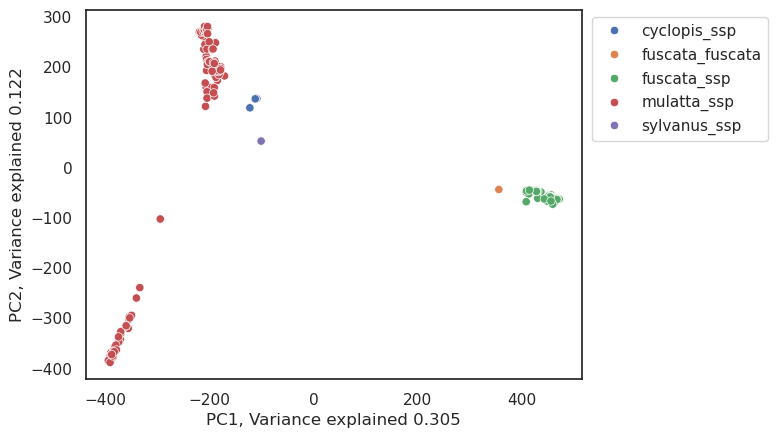

In [32]:
pcx = 0
pcy = 1
g = sns.scatterplot(data=pca_df_macaca, x="PC1", y="PC2", hue="SPECIES_SUBSPECIES")
g.set(xlabel="PC1, Variance explained {0:.3g}".format(pca_results.sample_pca_explained_variance_ratio[pcx].values),
      ylabel="PC2, Variance explained {0:.3g}".format(pca_results.sample_pca_explained_variance_ratio[pcy].values))
plt.legend(bbox_to_anchor=(1.39, 1))

Loading in all the Macaca autosomes.

In [33]:
xarray_l = []
for x in aut.CONTIG_ID:
    print(x)
    ds = sg.load_dataset("../zarr_data/Macaca_mulatta_ssp_pca/"+x, drop_variables=["variant_allele"])
    missing_filter = 0.0
    missing_rate = ds.call_genotype_mask[:,:,0].sum(axis=1).values/ds.call_genotype_mask[:,:,0].count(axis=1).values
    ds_subset = ds.isel(variants=(missing_rate <= missing_filter))
    xarray_l.append(sg.count_variant_alleles(ds_subset)[["variant_allele_count",
                                         "call_genotype", "call_genotype_mask"]])
ds_concat = xr.concat(xarray_l, dim="variants")

NC_041754.1
NC_041755.1
NC_041756.1
NW_021160144.1
NC_041757.1
NC_041758.1
NC_041759.1
NC_041760.1
NC_041761.1
NC_041762.1
NC_041763.1
NC_041764.1
NC_041765.1
NC_041766.1
NC_041767.1
NC_041768.1
NC_041769.1
NC_041770.1
NC_041771.1
NC_041772.1
NC_041773.1
NW_021160606.1
NW_021161850.1


In [34]:
pca_results = sg.pca(ds_concat).compute()

In [35]:
pca_df_macaca = pd.DataFrame(pca_results.sample_pca_projection,
                      columns=["PC{}".format(x+1) for x in range(10)])
pca_df_macaca["GVCF_ID"] = ds.sample_id
pca_df_macaca["SPECIES_SUBSPECIES"] = pca_df_macaca["GVCF_ID"].map(dict(zip(metadata_df.GVCF_ID, metadata_df.SPECIES+"_"+metadata_df.SUBSPECIES)))
pca_df_macaca["CHROM"] = "Autosome"
pca_df_macaca.to_csv("../results/Macaca_aut_pca.txt", sep="\t", index=False)

In [36]:
d_pca_var["Macaca_aut"] = pca_results.sample_pca_explained_variance_ratio
d_pca_var

{'Anubis_aut': <xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> Size: 40B
 array([0.24636586, 0.0728419 , 0.05497636, 0.05090902, 0.02618214,
        0.01719516, 0.01506165, 0.00830828, 0.00762447, 0.0073325 ],
       dtype=float32)
 Dimensions without coordinates: components,
 'Anubis_chrX': <xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> Size: 40B
 array([0.23003554, 0.06504869, 0.0522945 , 0.04609353, 0.02372572,
        0.01649078, 0.01514296, 0.00871438, 0.00811962, 0.00713975],
       dtype=float32)
 Dimensions without coordinates: components,
 'Macaca_chrX': <xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> Size: 40B
 array([0.30472714, 0.12218098, 0.04073111, 0.0207782 , 0.0127318 ,
        0.01169704, 0.01139953, 0.0110782 , 0.00774503, 0.00764806],
       dtype=float32)
 Dimensions without coordinates: components,
 'Macaca_aut': <xarray.DataArray 'sample_pca_explained_variance_ratio' (components: 10)> 

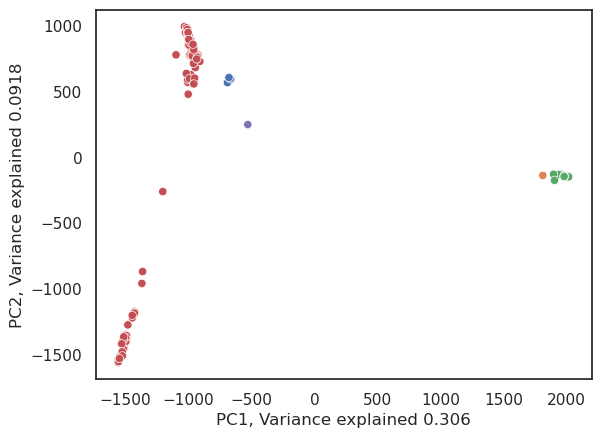

In [37]:
pcx = 0
pcy = 1
g = sns.scatterplot(data=pca_df_macaca, x="PC1", y="PC2", hue="SPECIES_SUBSPECIES", legend=False)
g.set(xlabel="PC1, Variance explained {0:.3g}".format(pca_results.sample_pca_explained_variance_ratio[pcx].values),
      ylabel="PC2, Variance explained {0:.3g}".format(pca_results.sample_pca_explained_variance_ratio[pcy].values))
#plt.legend(bbox_to_anchor=(1.39, 1))
f = g.get_figure()
f.savefig("../figures/Macaca_aut_pca.jpg", dpi=300)

In [45]:
pca_var_df = pd.DataFrame(d_pca_var)
pca_var_df.to_csv("../results/Pca_var_explained.txt", sep="\t", index=False)

Load and concat all dfs.

In [53]:
df_l = []
for df_path in glob.glob("../results/Papio*"):
    load_df = pd.read_csv(df_path, sep="\t")
    load_df["REFERENCE"] = "Papio_anubis"
    df_l.append(load_df)
for df_path in ["../results/Macaca_aut_pca.txt", "../results/Macaca_chrX_pca.txt"]:
    load_df = pd.read_csv(df_path, sep="\t")
    load_df["REFERENCE"] = "Macaca_mulatta"
    df_l.append(load_df)

In [54]:
pca_df = pd.concat(df_l)
#pca_df["CHROM"] = pca_df.CHROM.map({np.nan: "chrX", "AUTOSOMAL": "aut", "Autosomal": "aut"})

In [55]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,GVCF_ID,SPECIES_SUBSPECIES,CHROM,REFERENCE
0,-1314.15500,-481.048950,-79.903670,-177.589600,87.676476,-232.867610,17.973480,-466.458370,-144.201260,-142.710950,SAMEA112482952,anubis_ssp,Autosome,Papio_anubis
1,-1311.01320,-480.411000,-81.189770,-181.355410,78.546936,-243.192320,18.574009,-468.963800,-135.664300,-143.930020,SAMEA112482953,anubis_ssp,Autosome,Papio_anubis
2,-1299.62610,-474.224270,-82.798470,-172.017330,89.366165,-242.028730,13.115626,-485.181340,-159.039860,-175.012760,SAMEA112482954,anubis_ssp,Autosome,Papio_anubis
3,-1326.10970,-479.524500,-77.545810,-173.521180,67.107765,-234.092320,19.423548,-473.006350,-135.978910,-144.735580,SAMEA112482955,anubis_ssp,Autosome,Papio_anubis
4,-1316.86450,-480.720400,-81.895770,-177.288930,86.018840,-232.741800,15.504137,-464.708000,-133.302120,-151.378720,SAMEA112482956,anubis_ssp,Autosome,Papio_anubis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,-385.86383,-369.719670,2.190794,31.601757,-12.371671,-71.192940,14.501961,4.214672,43.265327,6.691655,SAMN41979685,mulatta_ssp,Chromosome X,Macaca_mulatta
179,-386.40094,-375.515660,0.618199,30.756376,-1.683115,-64.891540,15.008836,6.577417,73.624700,21.078953,SAMN41979691,mulatta_ssp,Chromosome X,Macaca_mulatta
180,-383.55550,-366.982540,0.265066,30.877666,-12.019595,-90.601970,16.334866,-0.198750,50.859722,8.363316,SAMN41979696,mulatta_ssp,Chromosome X,Macaca_mulatta
181,-388.51440,-372.609680,1.470052,21.563698,-16.700214,-65.930850,12.068750,0.294940,-2.067979,-2.284504,SAMN42715008,mulatta_ssp,Chromosome X,Macaca_mulatta


In [56]:
pca_df.to_csv("../results/Macaca_papio_pca.txt", sep="\t", index=False)